In [3]:
import os, sys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from src import settings
from src.utils import fileio, graph_utils
from networkx.algorithms.community import modularity
from networkx.algorithms.community import greedy_modularity_communities


def calculate_modularity(G):
    communities = list(greedy_modularity_communities(G.to_undirected()))  # Treat directed graph as undirected for modularity
    mod = modularity(G.to_undirected(), communities)  # Calculate modularity based on the undirected version
    
    return mod


def plot_density_mod(res, function_name, TREATMENT):
    for density, modularities in res.items():
        if modularities:
            plt.scatter(
                [density] * len(modularities), 
                modularities,
                label=f'Density {density}',
                alpha=0.01, 
                color = 'b'
                )

    for density, modularities in res.items():
        if modularities:
            plt.scatter(
                density, 
                sum(modularities) / len(modularities),
                # label=f'Density {density}',
                alpha=1, 
                color = 'r',
                s=15,
                )

    plt.axhline(y=0, color='white')
    plt.xlim(0, 100)
    plt.ylim(-1, 1)
    plt.xlabel('Density')
    plt.ylabel(f'{function_name}')
    plt.title(f'{TREATMENT}: {function_name} vs Density')
    plt.show()


config = fileio.get_config(settings.CONFIG_NAME)
TIME_WINDOWS = ['5', '10', '15' ,'20', '30', '60', '75', '90' ,'120', '240', '480']

graph_functions = [
        ('Degree centrality', lambda g: nx.degree_centrality(g)),
        ('Eigenvector centrality', lambda g: nx.eigenvector_centrality(g)),
        ('Closeness centrality', lambda g: nx.closeness_centrality(g)),
        # ('Weighted Degree (count)', lambda g: dict(nx.degree(g, weight='count'))),
        # ('Weighted Degree (duration(seconds))', lambda g: dict(nx.degree(g, weight='total_interaction_times')),),
        # ('Selectivity', lambda g: get_selectivity(g)),
        ('Betweenness centrality w=None', lambda g: nx.betweenness_centrality(g, weight=None)),
        ('Betweenness centrality w=count', lambda g: nx.betweenness_centrality(g, weight='count')),
        ('Betweenness centrality w=duration(seconds)', lambda g: nx.betweenness_centrality(g, weight='total_interaction_times'),),
        ('Clustering coefficient w=None', lambda g: nx.clustering(g, weight=None)),
        ('Clustering coefficient w=count', lambda g: nx.clustering(g, weight='count')),
        ('Clustering coefficient w=duration(seconds)', lambda g: nx.clustering(g, weight='total_interaction_times'),),
        # ('PageRank centrality', lambda g: nx.pagerank(g)),
    ]
for function_name, function_defintion in graph_functions:

    for TREATMENT in ['CS_10D']: # config["TREATMENTS"]:
        res = {i: [] for i in range(1, 101)}
        res_not_er = {i: [] for i in range(1, 101)}

        for TIME_WINDOW in TIME_WINDOWS:
            treatment = fileio.load_multiple_folders(
                os.path.join(settings.OUTPUT_DIR, "2_1_create_snapshots", f"{TIME_WINDOW}_sec_window", TREATMENT))
            
            for group_name, group_path in treatment.items():
                snapshot_graphs = fileio.load_files_from_folder(group_path, n_sort=True, file_format=".gml")
                total = pd.DataFrame()

                for i, graph_path in enumerate(snapshot_graphs.values()):
                    G = nx.read_gml(graph_path)
                    sys.exit()

                    if G.number_of_nodes() == 0: continue
                    
                    density = int(nx.density(G) *  100)
                    in_degrees = [G.in_degree(n) for n in G.nodes()]
                    out_degrees = [G.out_degree(n) for n in G.nodes()]

                    try: 
                        real_measures = function_defintion(G)
                        real_measures = list(real_measures.values())

                        res_er = []
                        for _ in range(100):
                            G_er = nx.DiGraph(nx.directed_configuration_model(in_degrees, out_degrees))
                            res_er.extend(list(function_defintion(G_er).values()))

                        er_measure_mean = np.mean(res_er)
                        res_not_er[density].extend(real_measures)
                        res[density].extend([x - er_measure_mean for x in real_measures])
                        sys.exit()
                    except:
                        continue
                    

        plot_density_mod(res_not_er, function_name, TREATMENT)
        # sys.exit()
        plot_density_mod(res, function_name, TREATMENT)

sys.exit()

SystemExit: 

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [19]:
import os
import networkx as nx
import pandas as pd
from src import settings
from src.utils import fileio
import networkx as nx
import matplotlib.pyplot as plt
import community

TREATMENT = "CsCh"
INPUT_DIR = os.path.join(settings.OUTPUT_DIR, "1_0_find_interactions", TREATMENT)
main_config = fileio.get_config(settings.CONFIG_NAME)
treatment = fileio.load_files_from_folder(INPUT_DIR)

densities = [0.10, 0.20, 0.33, 0.50]

graphs = []
res = []
samples = 0
for group_name, group_path in treatment.items():
    df_interactions = pd.read_csv(group_path, index_col=0)
    df_interactions = df_interactions.sort_values("start_of_interaction")
    last_idx = df_interactions.index[-1]
    run = True
    a=0
    while run:
        if samples > 130:
            run = False
            sys.exit()

        G = nx.DiGraph()
        G.add_nodes_from([f"fly{i}" for i in range(1, 13)]) 
        while nx.density(G) < 0.33:
            for idx, row in df_interactions.iterrows():
                if nx.density(G) > 0.35:break
                if idx == last_idx: run = False
                node_1, node_2 = row["node_1"], row["node_2"]
                duration = row["duration"]
                if G.has_edge(node_1, node_2):continue
                else:G.add_edge(node_1, node_2)

        graphs.append(G)

        # if not run: break
        # df_interactions = df_interactions.iloc[20:]

        # real_values = nx.betweenness_centrality(G, weight=False)
        # real_measures = nx.betweenness_centrality(G, weight=False)
        # real_measures = list(real_measures.values())

        # in_degrees = [G.in_degree(n) for n in G.nodes()]
        # out_degrees = [G.out_degree(n) for n in G.nodes()]
        # res_er = []
        # for _ in range(100):
        #     G_er = nx.DiGraph(nx.directed_configuration_model(in_degrees, out_degrees))
        #     res_er.extend(list(nx.betweenness_centrality(G_er,weight=False).values()))

        # er_measure_mean = np.mean(res_er)
        # m = [x - er_measure_mean for x in real_measures]
        # res.extend(m)

        # for v in m:
        # if samples % 5 == 0: # > 0.3:
            # b = nx.betweenness_centrality(G, weight=False)
            # nodes_to_color = [node for node, centrality in b.items() if (centrality - er_measure_mean) > 0.4]
            # plt.figure(figsize=(6, 5))
            # pos = nx.spring_layout(G)  # Layout for node positions
            # node_colors = ['red' if node in nodes_to_color else 'blue' for node in G.nodes()]
            # outdegree = [G.out_degree(node) * 200 for node in G.nodes()]  # Scale outdegree by a factor (100)
            # nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=outdegree, font_size=14, font_weight='bold')
            # plt.title(f'{samples} {group_name}')
            # plt.show()
            # partition = community.best_partition(G.to_undirected())
            # # Assign colors based on community
            # colors = [partition[node] for node in G.nodes()]
            # # Draw graph with colored communities
            # plt.figure(figsize=(6, 5))
            # nx.draw(G, node_color=colors, with_labels=True, cmap=plt.cm.rainbow, node_size=300)
            # plt.show()

        # b = nx.betweenness_centrality(G, weight=False)
        # max_betweenness_node = max(b, key=b.get)
        # partition = community.best_partition(G.to_undirected())
        # colors = [partition[node] for node in G.nodes()]
        # node_colors = ['yellow' if node == max_betweenness_node else plt.cm.rainbow(colors[i] / max(colors)) for i, node in enumerate(G.nodes())]

        # plt.figure(figsize=(4, 4))
        # pos = nx.spring_layout(G)
        # nx.draw(G, pos, node_color=node_colors, with_labels=True, cmap=plt.cm.rainbow, node_size=300)
        # plt.title(f'{samples} {group_name}')
        
        # plt.show()
        # samples+=1


KeyboardInterrupt: 

6589


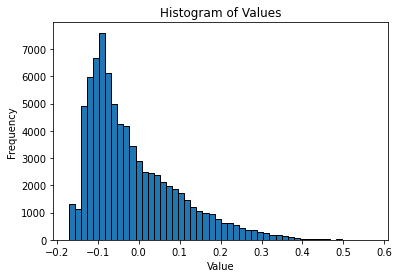

In [14]:
print(samples)
plt.hist(res, bins=50, edgecolor="black", alpha=1)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title(f"Histogram of Values")
plt.show()

In [1]:
import os, sys
import pandas as pd
import networkx as nx
from src import settings
from src.utils import fileio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_density(res, TREATMENT):
    data = []
    for key, values in res.items():
        for v in values:
            data.append([key, v])

    df = pd.DataFrame(data, columns=["X", "Y"])
    df["X"] = pd.Categorical(df["X"], categories=['5', '10', '15', '30', '60', '90', '120', '240', '480'], ordered=True)

    means = df.groupby("X")["Y"].mean()
    stds = df.groupby("X")["Y"].std()
    plt.figure(figsize=(8, 5))
    plt.errorbar(means.index, means, yerr=stds, fmt='o', capsize=5, color="black")
    plt.plot(means.index, means, linestyle="-", marker="o", color="black")

    plt.ylim(0, 1)
    plt.xlabel("Time Window (seconds)")
    plt.ylabel("Density (%)")
    plt.title("Density distribution in networks by Time Window")
    plt.show()


def plot_density_and_modularity(res_density, res_modularity, TREATMENT):
    data_density = []
    data_modularity = []

    for key, values in res_density.items():
        for v in values:
            data_density.append([key, v])

    for key, values in res_modularity.items():
        for v in values:
            data_modularity.append([key, v])

    df_density = pd.DataFrame(data_density, columns=["X", "Density"])
    df_modularity = pd.DataFrame(data_modularity, columns=["X", "Modularity"])
    df_density["X"] = pd.Categorical(df_density["X"], categories=TIME_WINDOWS, ordered=True)
    df_modularity["X"] = pd.Categorical(df_modularity["X"], categories=TIME_WINDOWS, ordered=True)
    means_density = df_density.groupby("X")["Density"].mean()
    stds_density = df_density.groupby("X")["Density"].std()
    means_modularity = df_modularity.groupby("X")["Modularity"].mean()
    stds_modularity = df_modularity.groupby("X")["Modularity"].std()
    plt.figure(figsize=(8, 5))

    plt.errorbar(means_density.index, means_density, yerr=stds_density, fmt='o', capsize=5, color="blue", label="Density")
    plt.plot(means_density.index, means_density, linestyle="-", marker="o", color="blue")
    plt.errorbar(means_modularity.index, means_modularity, yerr=stds_modularity, fmt='o', capsize=5, color="red", label="Modularity")
    plt.plot(means_modularity.index, means_modularity, linestyle="-", marker="o", color="red")
    plt.ylim(0, 1)
    plt.xlim(0, 480)

    plt.xlabel("Time Window (seconds)")
    plt.ylabel("Value")
    plt.title(f"Density and Modularity by Time Window ({TREATMENT})")
    plt.legend()
    plt.show()


config = fileio.get_config(settings.CONFIG_NAME)
TIME_WINDOWS = ['5', '10', '15', '20', '30', '60', '75', '90' ,'120', '240', '480']

for TREATMENT in config["TREATMENTS"]:
    res_density = {i: [] for i in TIME_WINDOWS}
    res_modularity = {i: [] for i in TIME_WINDOWS}

    for TIME_WINDOW in TIME_WINDOWS:
        INPUT_DIR = os.path.join(settings.OUTPUT_DIR, "2_1_create_snapshots", f"{TIME_WINDOW}_sec_window", TREATMENT)
        treatment = fileio.load_multiple_folders(INPUT_DIR)
        for group_name, group_path in treatment.items():
            snapshot_graphs = fileio.load_files_from_folder(group_path, n_sort=True, file_format=".gml")
            total = pd.DataFrame()
            for i, graph_path in enumerate(snapshot_graphs.values()):
                G = nx.read_gml(graph_path)
                if G.number_of_nodes() == 0:
                    continue

                res_density[TIME_WINDOW].append(nx.density(G))
                res_modularity[TIME_WINDOW].append(calculate_modularity(G))
    plot_density_and_modularity(res_density, res_modularity, TREATMENT)
    # plot_density(res_modularity, TREATMENT)

    sys.exit()

NameError: name 'calculate_modularity' is not defined

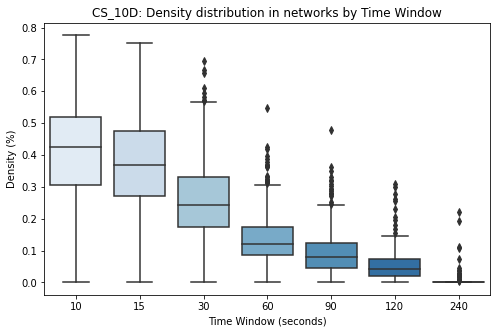

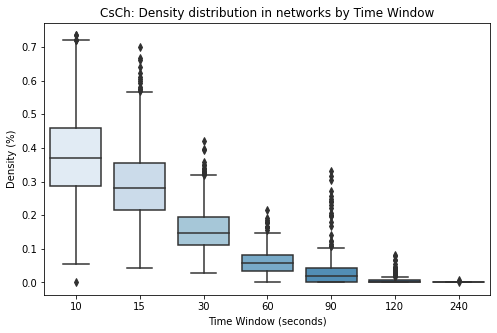

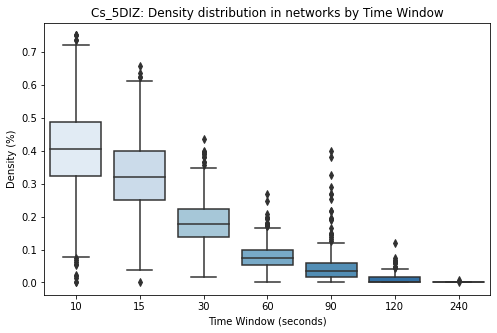

KeyboardInterrupt: 

In [94]:
import os, sys
import pandas as pd
import networkx as nx
from src import settings
from src.utils import fileio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def calculate_modularity(G):
    communities = list(greedy_modularity_communities(G.to_undirected()))  # Treat directed graph as undirected for modularity
    mod = modularity(G.to_undirected(), communities)  # Calculate modularity based on the undirected version
    
    return mod

def plot(res, TREATMENT):
    data = []
    for key, values in res.items():
        for v in values:
            data.append([key, v])

    df = pd.DataFrame(data, columns=["X", "Y"])
    df["X"] = pd.Categorical(df["X"], categories=['10', '15', '30', '60', '90', '120', '240'], ordered=True)

    plt.figure(figsize=(8, 5))
    sns.boxplot(x="X", y="Y", data=df, palette="Blues")
    plt.xlabel("Time Window (seconds)")
    plt.ylabel("Modularity")
    plt.title(f"{TREATMENT}: Density distribution in networks by Time Window")
    plt.show()

config = fileio.get_config(settings.CONFIG_NAME)
TIME_WINDOWS = ['10', '15' , '30', '60', '90' ,'120', '240']
for TREATMENT in config["TREATMENTS"]:
    res = {i: [] for i in TIME_WINDOWS}
    for TIME_WINDOW in TIME_WINDOWS:
        INPUT_DIR = os.path.join(settings.OUTPUT_DIR, "2_1_create_snapshots", f"{TIME_WINDOW}_sec_window", TREATMENT)
        treatment = fileio.load_multiple_folders(INPUT_DIR)
        for group_name, group_path in treatment.items():
            snapshot_graphs = fileio.load_files_from_folder(group_path, n_sort=True, file_format=".gml")
            total = pd.DataFrame()
            for i, graph_path in enumerate(snapshot_graphs.values()):
                G = nx.read_gml(graph_path)
                if G.number_of_nodes() == 0:
                    continue

                mod = calculate_modularity(G)
                res[TIME_WINDOW].append(mod)
    plot(res, TREATMENT)


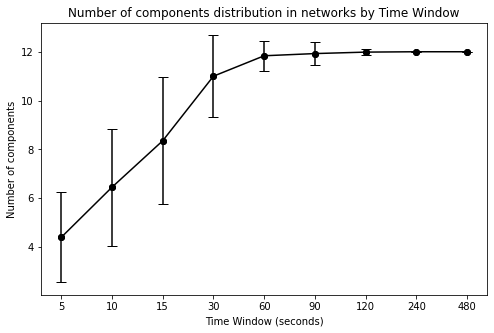

SystemExit: 

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [120]:
import os, sys
import pandas as pd
import networkx as nx
from src import settings
from src.utils import fileio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_density(res, TREATMENT):
    data = []
    for key, values in res.items():
        for v in values:
            data.append([key, v])

    df = pd.DataFrame(data, columns=["X", "Y"])
    df["X"] = pd.Categorical(df["X"], categories=['5', '10', '15', '30', '60', '90', '120', '240', '480'], ordered=True)

    means = df.groupby("X")["Y"].mean()
    stds = df.groupby("X")["Y"].std()
    plt.figure(figsize=(8, 5))
    plt.errorbar(means.index, means, yerr=stds, fmt='o', capsize=5, color="black")
    plt.plot(means.index, means, linestyle="-", marker="o", color="black")

    # plt.ylim(0, 1)
    plt.xlabel("Time Window (seconds)")
    plt.ylabel("Number of nodes")
    plt.title("Number of nodes distribution in networks by Time Window")
    plt.show()


config = fileio.get_config(settings.CONFIG_NAME)
TIME_WINDOWS = ['5', '10', '15', '20', '30', '60', '75', '90' ,'120', '240', '480']

for TREATMENT in config["TREATMENTS"]:
    res_noc = {i: [] for i in TIME_WINDOWS}


    for TIME_WINDOW in TIME_WINDOWS:
        INPUT_DIR = os.path.join(settings.OUTPUT_DIR, "2_1_create_snapshots", f"{TIME_WINDOW}_sec_window", TREATMENT)
        treatment = fileio.load_multiple_folders(INPUT_DIR)
        for group_name, group_path in treatment.items():
            snapshot_graphs = fileio.load_files_from_folder(group_path, n_sort=True, file_format=".gml")
            total = pd.DataFrame()
            for i, graph_path in enumerate(snapshot_graphs.values()):
                G = nx.read_gml(graph_path)
                if G.number_of_nodes() == 0:
                    continue
                
                connected_components = list(nx.connected_components(G.to_undirected()))
                largest_component = max(connected_components, key=len)

                res_noc[TIME_WINDOW].append(len(largest_component))
    plot_density(res_noc, TREATMENT)
    sys.exit()